# Nested sampling demonstration

In [ ]:
import numpy as np
import dynesty
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import dynesty
from dynesty import DynamicNestedSampler

## Define a distribution to sample

In [217]:

# Define a class to represent a 2D Gaussian component
class Gaussian2D:
    def __init__(self, mean, cov, weight=1.0):
        """
        Initialize a 2D Gaussian component.

        Args:
            mean (list or numpy.array): The [x, y] coordinates of the Gaussian's center.
            cov (list or numpy.array): The 2x2 covariance matrix defining the shape and orientation.
                                       Example: [[sigma_x^2, rho*sigma_x*sigma_y],
                                                 [rho*sigma_x*sigma_y, sigma_y^2]]
            weight (float): The weight of this Gaussian in the mixture model.
        """
        self.mean = np.array(mean)
        self.cov = np.array(cov)
        self.weight = weight
        # Create a multivariate normal random variable object for PDF calculation
        self.rv = multivariate_normal(mean=self.mean, cov=self.cov)

    def pdf(self, amp, x, y):
        """
        Calculate the probability density function value for a given (x, y) grid.

        Args:
            x (numpy.array): Meshgrid X coordinates.
            y (numpy.array): Meshgrid Y coordinates.

        Returns:
            numpy.array: PDF values for each point in the grid, scaled by the weight.
        """
        # Create a 3D array where the last dimension holds [x, y] pairs for multivariate_normal
        pos = np.empty(x.shape + (2,))
        pos[:, :, 0] = x
        pos[:, :, 1] = y
        return amp*self.rv.pdf(pos) * self.weight
    
    def pdf_val(self, amp, x, y):
        """
        Calculate the probability density function value for a given (x, y) grid.

        Args:
            x (numpy.array): Meshgrid X coordinates.
            y (numpy.array): Meshgrid Y coordinates.

        Returns:
            numpy.array: PDF values for each point in the grid, scaled by the weight.
        """
        # Create a 3D array where the last dimension holds [x, y] pairs for multivariate_normal
        pos = np.empty((2,))
        pos[0] = x
        pos[1] = y
        return amp*self.rv.pdf(pos) * self.weight
    

def create_distribution(x_min, x_max, y_min, y_max, num_points=200):
    """
    Create a 2D probability distribution function resembling the Indiana University logo ('IU').
    This is a conceptual approximation; precise shapes require more detailed parameter tuning.

    Args:
        x_min (float): Minimum x-coordinate for the grid.
        x_max (float): Maximum x-coordinate for the grid.
        y_min (float): Minimum y-coordinate for the grid.
        y_max (float): Maximum y-coordinate for the grid.
        num_points (int): Number of points along each axis to create the grid.

    Returns:
        tuple: (X, Y, Z) meshgrid arrays where Z contains the PDF values.
    """
    x = np.linspace(x_min, x_max, num_points)
    y = np.linspace(y_min, y_max, num_points)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X) # Initialize the Z (PDF) array with zeros

    # Define Gaussian components for each part of the IU logo
    gaussians = [
        # --- Components for 'I' ---
        # Main vertical bar of I
        Gaussian2D(mean=[.0, 0], cov=[[0.08, 0], [0, 8]], weight=1.0),
        #Gaussian2D(mean=[.0, -1], cov=[[0.08, 0], [0, 1.5]], weight=1.0),
        # Top horizontal bar of I
        Gaussian2D(mean=[0, 5.0], cov=[[0.6, 0], [0, 0.08]], weight=1.0),
        # Bottom horizontal bar of I
        Gaussian2D(mean=[-0, -5.0], cov=[[0.6, 0], [0, 0.08]], weight=1.0),

        # --- Components for 'U' ---
        # Left vertical bar of U
        Gaussian2D(mean=[-1.0, 0.75+0.5], cov=[[0.08, 0], [0, 1.0]], weight=1.0),
        # Right vertical bar of U
        Gaussian2D(mean=[1.0, 0.75+0.5], cov=[[0.08, 0], [0, 1.0]], weight=1.0),
        # Bottom curve of U (multiple smaller Gaussians for a smoother curve)
        Gaussian2D(mean=[-1, 0.75-0.9], cov=[[0.15, 0.05], [0.05, 0.1]], weight=0.8), # Left part of curve
        Gaussian2D(mean=[0, 0.75-1.0], cov=[[0.2, 0], [0, 0.1]], weight=1.0),    # Middle part of curve
        Gaussian2D(mean=[1, 0.75-0.9], cov=[[0.15, -0.05], [-0.05, 0.1]], weight=0.8), # Right part of curve
    ]

    ampI = [20, 1, 1, 8, 8, 4, 4, 4]
    # Sum the PDF contributions from all Gaussian components
    for ind, g in enumerate(gaussians):
        Z += g.pdf(ampI[ind], X, Y)

    # Normalize the total PDF (optional but good practice for a probability distribution)
    # The integral of the PDF over the entire space should be 1.
    # This normalization is an approximation as we're integrating over a finite grid.
    #Z /= np.sum(Z) * ((x_max - x_min) / num_points) * ((y_max - y_min) / num_points)

    return X, Y, Z



def eval_value(pars):
    """
    Creates a 2D probability distribution function resembling the Indiana University logo ('IU').
    This is a conceptual approximation; precise shapes require more detailed parameter tuning.

    Args:
        x_min (float): Minimum x-coordinate for the grid.
        x_max (float): Maximum x-coordinate for the grid.
        y_min (float): Minimum y-coordinate for the grid.
        y_max (float): Maximum y-coordinate for the grid.
        num_points (int): Number of points along each axis to create the grid.

    Returns:
        tuple: (X, Y, Z) meshgrid arrays where Z contains the PDF values.
    """
    x, y = pars
    #x = np.linspace(x_min, x_max, num_points)
    #y = np.linspace(y_min, y_max, num_points)
    #X, Y = np.meshgrid(x, y)
    #Z = np.zeros_like(X) # Initialize the Z (PDF) array with zeros
    Z = 0
    # Define Gaussian components for each part of the IU logo
    gaussians = [
        # --- Components for 'I' ---
        # Main vertical bar of I
        Gaussian2D(mean=[.0, 0], cov=[[0.08, 0], [0, 8]], weight=1.0),
        #Gaussian2D(mean=[.0, -1], cov=[[0.08, 0], [0, 1.5]], weight=1.0),
        # Top horizontal bar of I
        Gaussian2D(mean=[0, 5.0], cov=[[0.6, 0], [0, 0.08]], weight=1.0),
        # Bottom horizontal bar of I
        Gaussian2D(mean=[-0, -5.0], cov=[[0.6, 0], [0, 0.08]], weight=1.0),

        # --- Components for 'U' ---
        # Left vertical bar of U
        Gaussian2D(mean=[-1.0, 0.75+0.5], cov=[[0.08, 0], [0, 1.0]], weight=1.0),
        # Right vertical bar of U
        Gaussian2D(mean=[1.0, 0.75+0.5], cov=[[0.08, 0], [0, 1.0]], weight=1.0),
        # Bottom curve of U (multiple smaller Gaussians for a smoother curve)
        Gaussian2D(mean=[-1, 0.75-0.9], cov=[[0.15, 0.05], [0.05, 0.1]], weight=0.8), # Left part of curve
        Gaussian2D(mean=[0, 0.75-1.0], cov=[[0.2, 0], [0, 0.1]], weight=1.0),    # Middle part of curve
        Gaussian2D(mean=[1, 0.75-0.9], cov=[[0.15, -0.05], [-0.05, 0.1]], weight=0.8), # Right part of curve
    ]

    ampI = [20, 1, 1, 8, 8, 4, 4, 4]
    # Sum the PDF contributions from all Gaussian components
    for ind, g in enumerate(gaussians):
        Z += g.pdf_val(ampI[ind], x, y)

    return Z

### Visualize

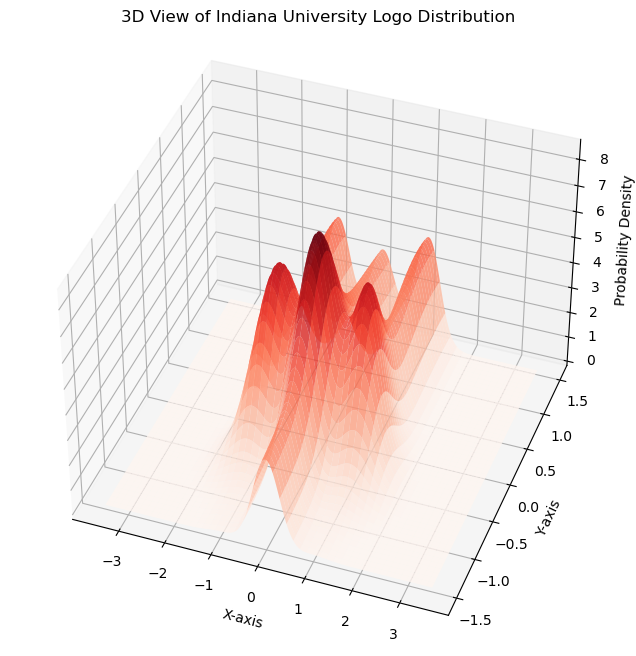

In [218]:

# --- Plotting Setup ---
# Define the bounds of the plotting area to fit the IU logo
x_min, x_max = -3.5, 3.5
y_min, y_max = -1.5, 1.5
num_points = 300 # Increased resolution for better detail on the logo

# Create the distribution data
X, Y, Z = create_distribution(x_min, x_max, y_min, y_max, num_points)


Zv = eval_value([4, 5])


# --- Plotting the Contour (Top-Down View) ---
#plt.figure(figsize=(10, 6)) # Adjusted figure size
#plt.contourf(X, Y, Z, levels=50, cmap='Reds') # Using 'Reds' colormap to match IU colors
#plt.colorbar(label='Probability Density')
#plt.title('2D Probability Distribution Resembling Indiana University Logo (Contour Plot)')
#plt.xlabel('X-axis')
#plt.ylabel('Y-axis')
##plt.grid(True, linestyle=':', alpha=0.6)
#plt.gca().set_aspect('equal', adjustable='box') # Maintain aspect ratio
#plt.show()

# --- Plotting a 3D Surface (Optional Perspective) ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='Reds', edgecolor='none', alpha=0.8)
ax.set_title('3D View of Indiana University Logo Distribution')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Probability Density')
ax.view_init(elev=40, azim=-70) # Adjusted camera angle for better view of IU
plt.show()


## Priors

In [219]:
def prior(parameters):
    ''' Mapping the unit cube to physical prior space '''
    
    X, Y = parameters

    X1 = X*10 -5
    Y1 = Y*10 -5
    return [X1, Y1]

## Sampler setup

In [221]:
dasmpler = DynamicNestedSampler(loglikelihood=eval_value,
                                prior_transform=prior,
                                ndim=2,
                                bound='multi')

## Run the sampler

In [222]:
dsampler.run_nested()

0it [00:00, ?it/s]


In [223]:
dsampler.results

         niter: 13239
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 21.885538583614363
       samples: array([[ 4.97593421e+00,  1.80968357e+00],
       [ 4.99584422e+00,  1.69146673e+00],
       [-4.86390723e+00,  1.93036563e+00],
       ...,
       [-5.31763907e-04, -2.32717077e-01],
       [-5.99804690e-04, -2.33366332e-01],
       [ 1.97629669e-04, -2.34780056e-01]])
    samples_id: array([2484,  297,  388, ...,  422,  424,  326])
 samples_batch: array([4, 0, 0, ..., 0, 0, 0])
    samples_it: array([9493,    0,    0, ..., 5077, 4299, 5181])
     samples_u: array([[0.99759342, 0.68096836],
       [0.99958442, 0.66914667],
       [0.01360928, 0.69303656],
       ...,
       [0.49994682, 0.47672829],
       [0.49994002, 0.47666337],
       [0.50001976, 0.47652199]])
     samples_n: array([1000, 1000, 1000, ...,    3,    2,    1])
         logwt: array([-7.60190196, -6.90975428, -6.91075378, ..., -8.38529559,
       -8.38526967, -8.38523135])
          logl: array([3.8

In [147]:
dsampler.results.samples.shape

(13239, 2)

In [148]:

dsampler.results

         niter: 13239
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 21.885538583614363
       samples: array([[ 4.97593421e+00,  1.80968357e+00],
       [ 4.99584422e+00,  1.69146673e+00],
       [-4.86390723e+00,  1.93036563e+00],
       ...,
       [-5.31763907e-04, -2.32717077e-01],
       [-5.99804690e-04, -2.33366332e-01],
       [ 1.97629669e-04, -2.34780056e-01]])
    samples_id: array([2484,  297,  388, ...,  422,  424,  326])
 samples_batch: array([4, 0, 0, ..., 0, 0, 0])
    samples_it: array([9493,    0,    0, ..., 5077, 4299, 5181])
     samples_u: array([[0.99759342, 0.68096836],
       [0.99958442, 0.66914667],
       [0.01360928, 0.69303656],
       ...,
       [0.49994682, 0.47672829],
       [0.49994002, 0.47666337],
       [0.50001976, 0.47652199]])
     samples_n: array([1000, 1000, 1000, ...,    3,    2,    1])
         logwt: array([-7.60190196, -6.90975428, -6.91075378, ..., -8.38529559,
       -8.38526967, -8.38523135])
          logl: array([3.8

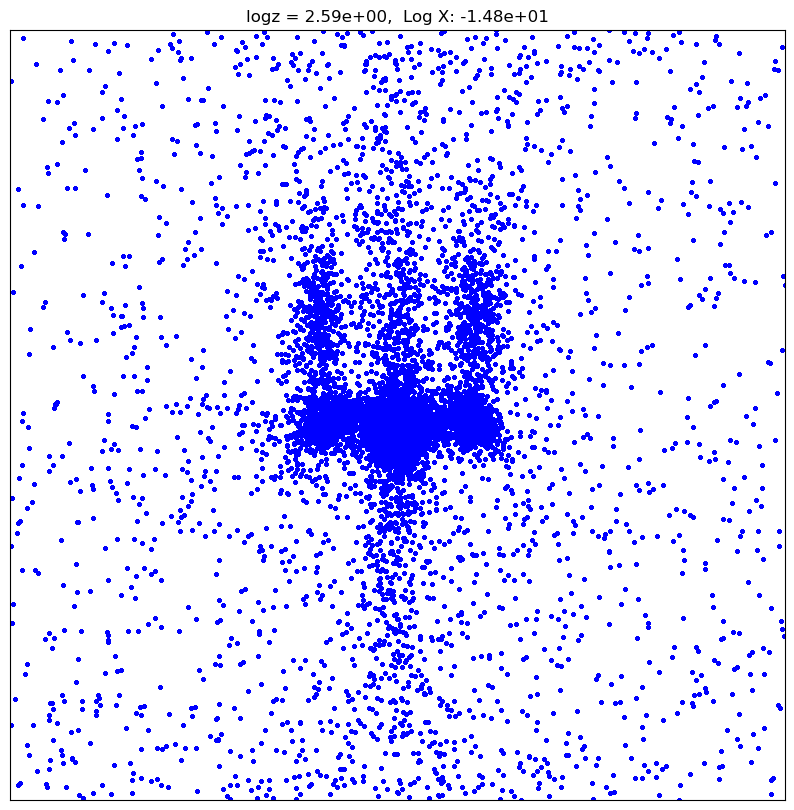

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

import os
if not os.path.isdir('figs'):
    os.mkdir('figs')
    
for index in np.arange(0, dsampler.results.niter, 10):
    
    lind = int(index/10)
    ax.scatter(dsampler.results.samples[:index, 0], dsampler.results.samples[:index, 1], s=2, c='b')   
    lind_str = str(lind)
    lstr = len(lind_str)

    nz = 5 - lstr

    lstr = nz*'0' + lind_str
    #logz_i = round(dsampler.results.logz[index], 3)
    logz_i = dsampler.results.logz[index]
    pm = dsampler.results.logvol[index] #np.exp(-(index/500))
    ax.set_title(f"logz = {logz_i:.2e},  Log X: {pm:.2e}")
    fig.savefig(f"figs/{lstr}.png")
    #plt.close()

plt.close()
